In [2]:
import os
import pickle
import sys
import time

import numpy as np
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc, build_default_source
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from hydra import initialize, compose
from pyHalo.preset_models import CDM
from pyHalo.plotting_routines import plot_multiplane_convergence

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.utils import util

In [5]:
lens = SampleStrongLens()

z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
log_m_host = np.log10(lens.get_main_halo_mass())
r_tidal = 0.25

subhalo_cone = 11
los_normalization = 0.

In [6]:
cdm_realization = CDM(z_lens, z_source, log_m_host=log_m_host, r_tidal=r_tidal,
                          cone_opening_angle_arcsec=subhalo_cone,
                          LOS_normalization=los_normalization)

print(f'Realization contains {len(cdm_realization.halos)} halos.')

Realization contains 164 halos.


In [7]:
# pickle it
with open(os.path.join(pickle_dir, 'cdm_subhalos_for_sample'), 'ab') as results_file:
        pickle.dump(cdm_realization, results_file)

In [8]:
# unpickle to reproduce plots
with open(os.path.join(pickle_dir, 'cdm_subhalos_for_sample'), 'rb') as results_file:
        cdm_realization = pickle.load(results_file)

In [9]:
print(len(cdm_realization.halos))

183


<AxesSubplot: >

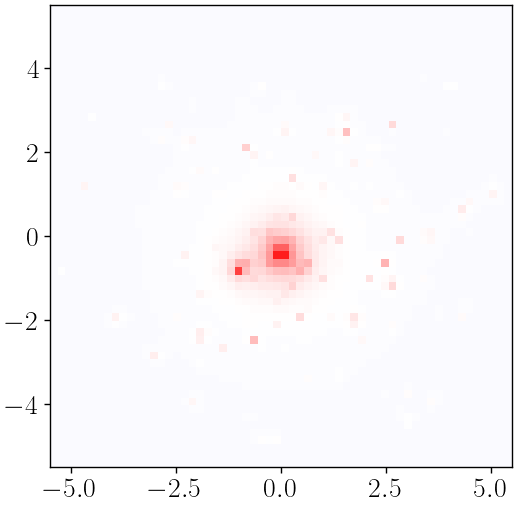

In [10]:
plot_multiplane_convergence(cdm_realization, 
                                  npix=60,
                             cone_opening_angle_arcsec=subhalo_cone, 
                             lens_model_list_macro=None, 
                             kwargs_lens_macro=None, 
                             redshift_list_macro=None,
                                 show_critical_curve=False,
                                 vmin_max=0.01)

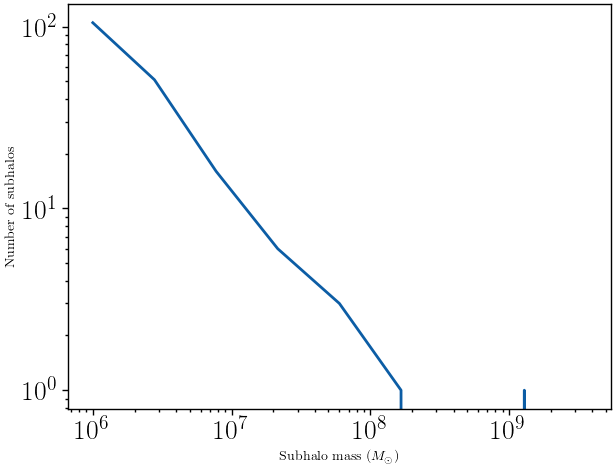

In [11]:
cdm_halo_masses = [halo.mass for halo in cdm_realization.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Subhalo mass ('+r'$M_{\odot}$)')
ax.set_ylabel('Number of subhalos')

fig.savefig(os.path.join(figure_dir, 'shmf.png'))

In [12]:
print(cdm_realization.astropy_instance)

FlatLambdaCDM(H0=67.5 km / (Mpc s), Om0=0.309, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.049)
